# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Part I. Load Data

This part of the script load the data from the  .json files, and briefly check the loaded data

In [ ]:
#import packages

import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# take a look at the portfolio dataframe
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


We notice that for 'informational' offers, there is no reward values

In [3]:
# take a look at the profile dataframe
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


we found that there are some mising values in this dataframe.

In [4]:
#take a look at the transcript dataframe
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


With some detailed eximination, we found that in the 'value' column it is a dictionary with key as 'offer id' for all offer related transactions (i.e., offer receive, offer viewed and offer completed), and the value as offer ids. For 'offer completed' transacations, the 'value' cell also include the reward value ('reward' as key, and reward amount as value). For transaction events which means the user make an purchase, and the 'value' cell includes the purchase amount ('amount' as key and the purchase amount as value)

In [5]:
#check if there is any null in porfolio dataframe
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [6]:
# check if there is any null in profile dataframe
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [7]:
# check to see how many users
profile.shape

(17000, 5)

Apparently there are 2175 null values in gender and income columns, and if we check the head of profile dataframe, we also found that the age is 118 for all the users without gender and income information. Since we want to better understand how gender, age and income will affect the effetiveness of offers, we decided to drop these users. These users acounts for 2175/17000 = 12.8% of the users.

In [8]:
# check if there is any null in transcirpt dataframe
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

### Part II. Data Cleaning

Now we need to process the data to make them ready for explortary analysis

The offer ids in portfolio dataframe is very long, which is difficult to refer to and might be a problem when create data visulizations, therefore here we conver offer ids into shorter unique ids.

In [9]:
# get the keys for the short id to the long id
def get_idkey(id_series):
    
    '''
    This function gets a short id key for the long offer_id or user id
    
    INPUT = a column in the dataframe with ids
    
    OUTPUT = the dictionary with out id as key and new id as value
    
    '''    
    idk = dict()
    ids = 1
    
    for item in id_series.unique():
        idk[item] = ids
        ids += 1
    return idk

First, process the portfolio dataframe, which mainly includes create dummy columns for the 'channel' column, replace the long offer id with short ones

In [10]:
# process the portfolio dataframe

def process_portfolio(portfolio):
    
    '''
    This function takes in the original portfolio dataframe clean the data including create offer channels and
    simply offer ids, and returns the cleaned dataframe 
    
    INPUT: portfolio - original portfolio dataframe
    
    OUTPUT: portfolio_cleaned - processed porfolio dataframe
    '''

    # make a copy of the portfolio dataframe
    portfolio_cleaned = portfolio.copy()
    
    # get the keys for long offer ids get a new column with new short offer ids
    id_keys = get_idkey(portfolio_cleaned['id'])
    portfolio_cleaned['offer id'] = portfolio_cleaned['id'].map(id_keys)
    
    # covert 'channels' column to numberical
    portfolio_cleaned['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio_cleaned['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio_cleaned['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    portfolio_cleaned['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
  

    # drop the orinal 'channels' and 'id' columns
    portfolio_cleaned.drop(['channels', 'id'], axis = 1, inplace = True)
    # re-arrange columns
    cols = ['offer id', 'offer_type', 'web', 'email', 'mobile','social', 'reward', 'difficulty', 'duration']
    portfolio_cleaned = portfolio_cleaned[cols]
    
    return portfolio_cleaned

In [11]:
# get the processed porfolida datarame
portfolio_cleaned = process_portfolio(portfolio)
portfolio_cleaned

,offer id,offer_type,web,email,mobile,social,reward,difficulty,duration
0,1,bogo,0,1,1,1,10,10,7
1,2,bogo,1,1,1,1,10,10,5
2,3,informational,1,1,1,0,0,0,4
3,4,bogo,1,1,1,0,5,5,7
4,5,discount,1,1,0,0,5,20,10
5,6,discount,1,1,1,1,3,7,7
6,7,discount,1,1,1,1,2,10,10
7,8,informational,0,1,1,1,0,0,3
8,9,bogo,1,1,1,1,5,5,5
9,10,discount,1,1,1,0,2,10,7


Before we process the profile dataframe, as we find out in the Load Data section, this dataframe contains some null values. And since the rows with missing 'Gender' and 'Income' values have a constant "Age" Value of 118, and the total missing rows with missing values are about 12% of the total values. here we decided to drop these rows. 

After droping the rows with missing values, we would like to check how the age and income distribution of the users.

In [13]:
# Check the age and income distribution of the users
profile[['age','income']].dropna().describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


The minimum Age of the users are 18 and the maximium is 101. The minimum income of the registered users is 30,000 USD and maxiumim is 120,000 USD. In order to better under stand users within different income and age groups, we decided to break the users into 3 different age and income groups. Based on the age and income range, the users are devided into 3 age groups, 18 to 35 years old, 35 to 65 years old, and older than 65 years old, and 3 income groups, <50000 USD/yr, 50K to 80K USD/yr and >80K year
    
We also added a column showing the member's membership age by extracing the date when the user fist became a member, and break the users into 3 membership age groups, 0-4 years, 4-6 years and older than 6 years

In [14]:
# the function to process profile dataframe
def process_profile(profile):
    '''
    clean the profile dataframe
    
    INPUT: profile dataframe
    
    OUTPUT: cleaned profile dataframe
    '''
    
    #drop the null values in gender and income; the age value in those rows
    # are 118 which also indicate that the true age is not available for these
    # users
    
    profile_cleaned = profile.copy()
    profile_cleaned.dropna(axis = 0, inplace = True)
    
    # convert become_member_on to datetime format
    profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'], format='%Y%m%d')
    # create a new column for the member's membership age
    profile_cleaned['membership age'] = (datetime.datetime.today().date() - profile_cleaned['became_member_on'].dt.date).dt.days
    
    # seperate users into 3 age groups
    profile_cleaned['age_18-35'] = profile['age'].apply(lambda x : 1 if x <=35 else 0)
    profile_cleaned['age_35-65'] = profile['age'].apply(lambda x : 1 if (x > 35) & (x <=65) else 0)
    profile_cleaned['age_65'] = profile['age'].apply(lambda x : 1 if x > 65 else 0)
    
    # seperate users into 3 income groups
    profile_cleaned['income_30K-50K'] = profile['income'].apply(lambda x : 1 if x <= 50000 else 0)
    profile_cleaned['income_50K-80K'] = profile['income'].apply(lambda x : 1 if (x > 50000) & (x <= 80000) else 0)
    profile_cleaned['income_80K'] = profile['income'].apply(lambda x : 1 if x > 80000 else 0)
    
    # sepearate users into 3 gender groups
    profile_cleaned['M'] = profile['gender'].apply(lambda x : 1 if x == 'M' else 0)
    profile_cleaned['F'] = profile['gender'].apply(lambda x : 1 if x == 'F' else 0)
    profile_cleaned['O'] = profile['gender'].apply(lambda x : 1 if x == 'O' else 0)
    
    # sepearate users into 3 gender groups
    profile_cleaned['member_age_0-4'] = profile_cleaned['membership age'].apply(lambda x : 1 if x  <= 1460 else 0)
    profile_cleaned['member_age_4-6'] = profile_cleaned['membership age'].apply(lambda x : 1 if (x > 1460) & (x <= 2190) else 0)
    profile_cleaned['member_age_6'] = profile_cleaned['membership age'].apply(lambda x : 1 if x >2190 else 0)
    
    
    return profile_cleaned
    

In [15]:
# process the original profile dataframe
profile_cleaned = process_profile(profile)
profile_cleaned.head()

,gender,age,id,became_member_on,income,membership age,age_18-35,age_35-65,age_65,income_30K-50K,income_50K-80K,income_80K,M,F,O,member_age_0-4,member_age_4-6,member_age_6
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1543,0,1,0,0,0,1,0,1,0,0,1,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1610,0,0,1,0,0,1,0,1,0,0,1,0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1258,0,0,1,0,1,0,1,0,0,1,0,0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1334,0,1,0,0,1,0,1,0,0,1,0,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1424,0,1,0,0,1,0,1,0,0,1,0,0


offer ids, rewards amount, and transaction amountNow we need to process the transcript dataframe. We want to extract the offer ids, rewards amount, and transaction amount from the 'value' column. We also replace the offer id with id keys we set previously. Lastly we want to get dummy columns for the 'event' column.

In [16]:
def process_transcript(transcript):
    '''
    process the transcript dataframe
    
    INPUT transcript dataframe
    
    OUTPUT cleanned transcript dataframe
    '''
    # create a copy of the dataframe
    transcript_cleaned = transcript.copy()
    
    # extract the values from the 'value' cell and allocate data to seperate columns
    for i, row in transcript_cleaned.iterrows():
        offer_id = None
        reward = None
        amount = None
    
        if 'offer_id' in transcript_cleaned.iloc[i]['value']:
            offer_id =  transcript_cleaned.iloc[i]['value']['offer_id']
        if 'offer id' in transcript_cleaned.iloc[i]['value']:
            offer_id = transcript_cleaned.iloc[i]['value']['offer id']
        if 'reward' in transcript_cleaned.iloc[i]['value']:
            reward = transcript_cleaned.iloc[i]['value']['reward']
        if 'amount' in transcript_cleaned.iloc[i]['value']:
            amount = transcript_cleaned.iloc[i]['value']['amount']
        
        transcript_cleaned.at[i, 'offer id'] = offer_id
        transcript_cleaned.at[i, 'reward'] = reward
        transcript_cleaned.at[i, 'amount'] = amount
    
    # drop the original 'value' column
    transcript_cleaned.drop('value', axis = 1, inplace = True)
    
    # get the key from portfolio dataframe
    id_keys = get_idkey(portfolio['id'])
    # map the keys to transcript dataframe
    transcript_cleaned['offer id'] = transcript_cleaned["offer id"].map(id_keys)
    
    # drop the duplicated rows in this dataframe
    transcript_cleaned.drop_duplicates(inplace=True)
    
    # get dummies columns for 'event' column
    event = pd.get_dummies(transcript_cleaned['event'])
    transcript_cleaned = pd.concat([transcript_cleaned, event.set_index(transcript_cleaned.index)], axis=1)

    
    return transcript_cleaned

    

In [17]:
transcript_cleaned = process_transcript(transcript)

In [18]:
transcript_cleaned

,person,event,time,offer id,reward,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,4.0,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,10.0,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,7.0,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,2.0,NaN,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,NaN,1.59,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,NaN,9.53,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,NaN,3.61,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,NaN,3.53,0,0,0,1


Now we finish process the 3 dataframes. The next step is to perform exploretary analysis on these datasets.

### Part III.Exploratory Analysis

In this part we want to use exploratory analysis to understand how each user group respond to offers with different characterisitcs.

#### 3.1  User Demographics

First we want to check the user demographics

In [19]:
# get descriptive stastics about the age, income and membership age of the users.
profile_cleaned[['age','income', 'membership age']].describe()

,age,income,membership age
count,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,1689.478988
std,17.383705,21598.299410,419.205158
min,18.000000,30000.000000,1167.000000
25%,42.000000,49000.000000,1375.000000
50%,55.000000,64000.000000,1525.000000
75%,66.000000,80000.000000,1964.000000
max,101.000000,120000.000000,2990.000000


In [25]:
# get information on the gender of the users
profile_cleaned.groupby('gender')['id'].count()

gender
F    6129
M    8484
O     212
Name: id, dtype: int64

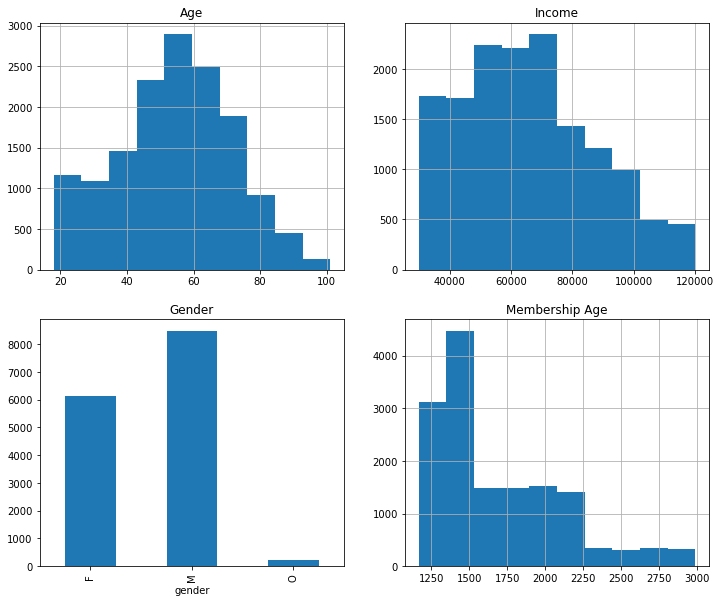

In [26]:
# create visualization of the user demographic data
fig, axs = plt.subplots(2, 2, figsize = (12,10))

# get the age distribution of the users
profile_cleaned['age'].hist(ax = axs[0,0])
axs[0, 0].set_title('Age')

# get the age distribution of the users
profile_cleaned['income'].hist(ax = axs[0,1])
axs[0, 1].set_title('Income')

# get the gender distribution of the users
profile_cleaned.groupby('gender')['id'].count().plot(kind = 'bar', ax = axs[1,0])
axs[1, 0].set_title('Gender')

# get the membership age distribution
profile_cleaned['membership age'].hist(ax = axs[1,1])
axs[1,1].set_title('Membership Age')

plt.show()

The age of the users shows a normal distribution, with the oldest users at age 101, and the youngest users at age 18, and the mean age of the users are about 54 year old, with the highest number of users falls under the 50-60 years old age group. The income of the users shows a skewed normal distribution, with more users have a income less than 75K comparing to those with higher income. The gender distribution data show that there are 8484 male users and 6129 female users and 212 users identified as gender O. The membership age distribution data shows that most users have a relatively short membership age (since we are not sure when this project was origianlly initiated, the user with shortest membership age is about 3 year) clost to 3 years, And the majority of the users have a membership age between 3 to 4 years. And the user with the oldest acount have a membership age of about 8 years.

#### 3.2 Offer Information

Now let's take a look at how each offer diffienciate from each other.

In [27]:
portfolio_cleaned

,offer id,offer_type,web,email,mobile,social,reward,difficulty,duration
0,1,bogo,0,1,1,1,10,10,7
1,2,bogo,1,1,1,1,10,10,5
2,3,informational,1,1,1,0,0,0,4
3,4,bogo,1,1,1,0,5,5,7
4,5,discount,1,1,0,0,5,20,10
5,6,discount,1,1,1,1,3,7,7
6,7,discount,1,1,1,1,2,10,10
7,8,informational,0,1,1,1,0,0,3
8,9,bogo,1,1,1,1,5,5,5
9,10,discount,1,1,1,0,2,10,7


For this project we only have 10 offers, and from this table, we can see that we have 3 offer types "BOGO", "Discount" and "Informational". The offers were sent out through four different channels, "web", "email", "mobile", and "social". All the offers were sent out through at least 2 channels. Information about the reward, the difficuly and duration of the offer is also provided in this table, which chould be used in the classification study later in this project. 

#### 3.3 Offer Performance

Now let's check how well each offer performed among users. The merit we want to check includes:
- The offer view and complete status 
- The cost of completed offers
- The revenue the offers generated

##### 3.3.1 The offer event status

From the data shown below, it is clear the amount of offers of each Offer send to users are about the same (around 7500), however, the amount of offers viewed by users and the offers completed by users are significantly different. For offer 1, 2, 6, 7 8 and 9, the number of viewed offers is much higher other offers. For offer 3m 4, 5 and 10 the number of people view the offer is less, but at same time, the number of viewed offer is closer to completed offer comparing to offer 1,2,6,7 and 9. Especially for offer 4 and 5, the number of completion is actually higher than number viewed.

And if we check the portfolio dataframe for each offer's characteristics, it seems that the offers with high views have social media as their delivery channel. At this stage, we didn't see any particular trend on other factors affecting the offer view and completion.

          offer received  offer viewed  offer completed
offer id                                               
1                 7658.0        6716.0           3635.0
2                 7593.0        7298.0           3301.0
3                 7617.0        4144.0              0.0
4                 7677.0        4171.0           4303.0
5                 7668.0        2663.0           3340.0
6                 7646.0        7337.0           5112.0
7                 7597.0        7327.0           5265.0
8                 7618.0        6687.0              0.0
9                 7571.0        7264.0           4262.0
10                7632.0        4118.0           3964.0


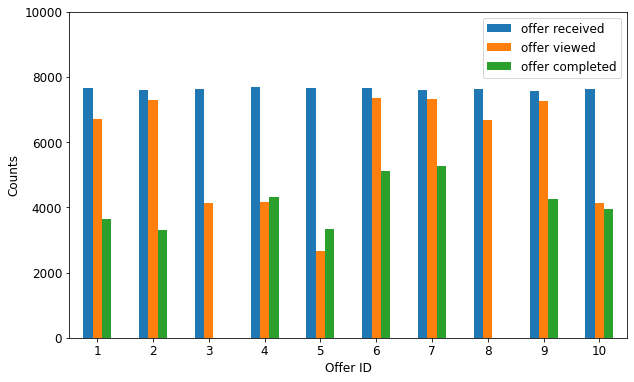

In [28]:
# get offer event from the transcript dataframe
offer = transcript_cleaned[transcript_cleaned['offer id'].notnull()].copy()
offer['offer id'] = offer['offer id'].astype(int)
offer.dropna(axis = 1, how = 'all', inplace = True)
offer.drop(['event','transaction'], axis =1, inplace = True)

#count how many offers were reveived, viewed and completed by users
offer_event = offer.groupby('offer id')[['offer received', 'offer viewed', 'offer completed']].sum()
print(offer_event)

#create visualization

ax = offer_event.plot(kind = 'bar', figsize = (10,6), fontsize = 12, ylim =[0, 10000], rot = 0)
ax.legend(loc = 1, fontsize=12)
xlabel = ax.set_xlabel('Offer ID', fontsize = 12)
ylabel = ax.set_ylabel('Counts', fontsize = 12)

##### 3.3.2 Offer Cost

From the analysis below,  offer 1 and 2 costs the most while offer 10 costs the least. And the cost ranges from 7928 USD to 36350 USD. Offer 3 and offer 8 have no "cost" because they have no rewards values.

offer id
10     7928.0
7     10530.0
6     15336.0
5     16700.0
9     21310.0
4     21515.0
2     33010.0
1     36350.0
Name: reward, dtype: float64


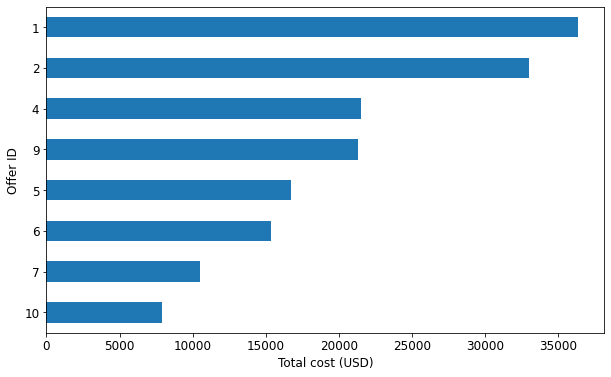

In [29]:
# Calculate the offer cost
# the offer cost is calcuated from when a offer is completed, how much rewards the user gets during a transaction
offer_cost = offer[offer['offer completed'] == 1].groupby('offer id')['reward'].sum()
print(offer_cost.sort_values())

ax = offer_cost.sort_values().plot(kind = 'barh', fontsize = 12, figsize = (10, 6))
xlabel = ax.set_xlabel('Total cost (USD)', fontsize = 12)
ylabel = ax.set_ylabel('Offer ID', fontsize = 12)

##### 3.3.2 Offer Revenue

From the analysis below, for those offers does have rewards, offer 7 generates the most revenue at 96900 USD while offer 4 generate the least revenue at 77066 USD. For infomational offers, we estimated the revenue by calculate the amount of purchase after the user view the offer, and offer 8 generated an estimated revenue of 10031 USD while offer 3 generated 5486 USD. 

In [30]:
# get all the purchase event fromthe transcript dataframe
purchase = transcript_cleaned[transcript_cleaned['event']=='transaction'].copy()
# drop offer event related columns, since all those columns have value of 0 
purchase.drop(['event', 'offer completed', 'offer received', 'offer viewed'], axis =1, inplace = True)
# drop columns with all null values
purchase.dropna(how = 'all', axis =1, inplace = True)

offer id
3      5486.17
8     10031.30
4     77066.31
2     78562.14
10    81687.95
9     83146.93
5     85985.53
1     87109.94
6     89848.17
7     96900.08
Name: amount, dtype: float64


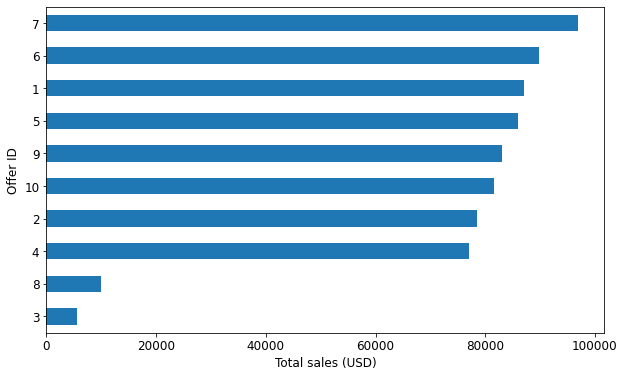

In [31]:
# now combine the offer event and purache event together by user and time to create a joint dataframe
offer_purchase = pd.merge(offer, purchase, how = 'left', on = ['person', 'time'])

# For offer does have offer completed event, we can calculate the revenue generated from complete the offer
# Here we consider that the transaction amount is the amount after offer applied (net revenue).
offer_sales = offer_purchase[(offer_purchase['offer completed'] == 1) & 
                             (offer_purchase['transaction']==1)].groupby('offer id')['amount'].sum()


# For offers that don't have offer completed event, and there is no rewards value
# Here we consider those purchase happend at the same time when the user view the offer 
# as the offer successfully influence the users to make a purchase, and that amount is taken into account as revenue by this offer
potential_sales = offer_purchase[((offer_purchase['offer id'] ==3) | (offer_purchase['offer id'] ==8)) 
               & ((offer_purchase['offer viewed']== 1)& (offer_purchase['transaction']== 1))
              ].groupby('offer id')['amount'].sum()

# combine all the offers together
offer_revenue = offer_sales.append(potential_sales)
# show the revenue
print(offer_revenue.sort_values())

#create visualization
ax = offer_revenue.sort_values().plot(kind = 'barh', fontsize = 12, figsize = (10, 6))
xlabel = ax.set_xlabel('Total sales (USD)', fontsize = 12)
ylabel = ax.set_ylabel('Offer ID', fontsize = 12)

Now lets combine cost and revenue together

           reward    amount
offer id                   
1         36350.0  87109.94
2         33010.0  78562.14
3             NaN   5486.17
4         21515.0  77066.31
5         16700.0  85985.53
6         15336.0  89848.17
7         10530.0  96900.08
8             NaN  10031.30
9         21310.0  83146.93
10         7928.0  81687.95


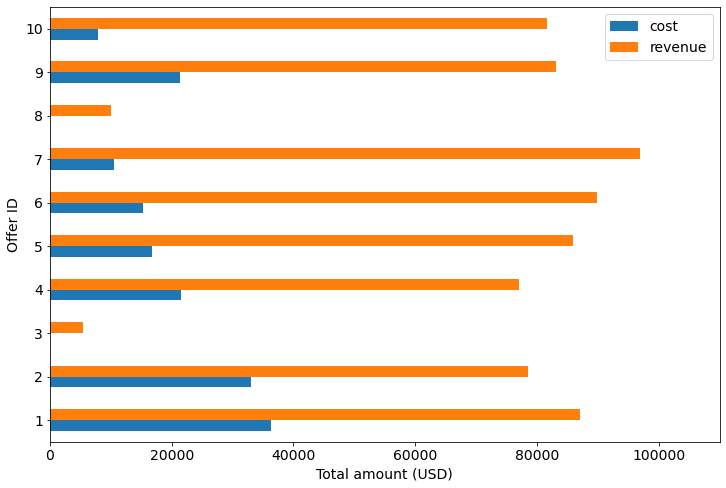

In [33]:
#put cost and revenue together
cost_revenue = pd.concat([offer_cost, offer_revenue], axis = 1)
#show the result
print(cost_revenue)

#create visulization
ax = cost_revenue.plot(kind = 'barh', fontsize = 14, figsize = (12, 8), xlim = (0,110000))
ax.legend(['cost', 'revenue'], loc = 0, fontsize=14)
xlabel = ax.set_xlabel('Total amount (USD)', fontsize = 14)
ylabel = ax.set_ylabel('Offer ID', fontsize = 14)

##### 3.3.4 Summary

Finally, we put the cost and revenue together, from the revenue vs. cost stand point, on one hand, offer 7 is the most successful promotion, because it generated the highest revenue and has the lowest cost among offers that have rewards. And If we check back what is the charater of offer 7, it is a "Discount" type of offer, and it was delivered through all channels to users, it has the least amount of rewards (2 USD) among all offers, and a relatively high difficultly, but more importantly, it has a long duration of 10 days. On the other hand, offer 2 is the least successful.Offer 2 is a "BOGO" offer, it was also delievered through all channels, it has the highest rewards, same difficulty as offer 7, and a 7 days durations.

Merge Offer and purchase information with the portfolio to see how offer features affects its performance

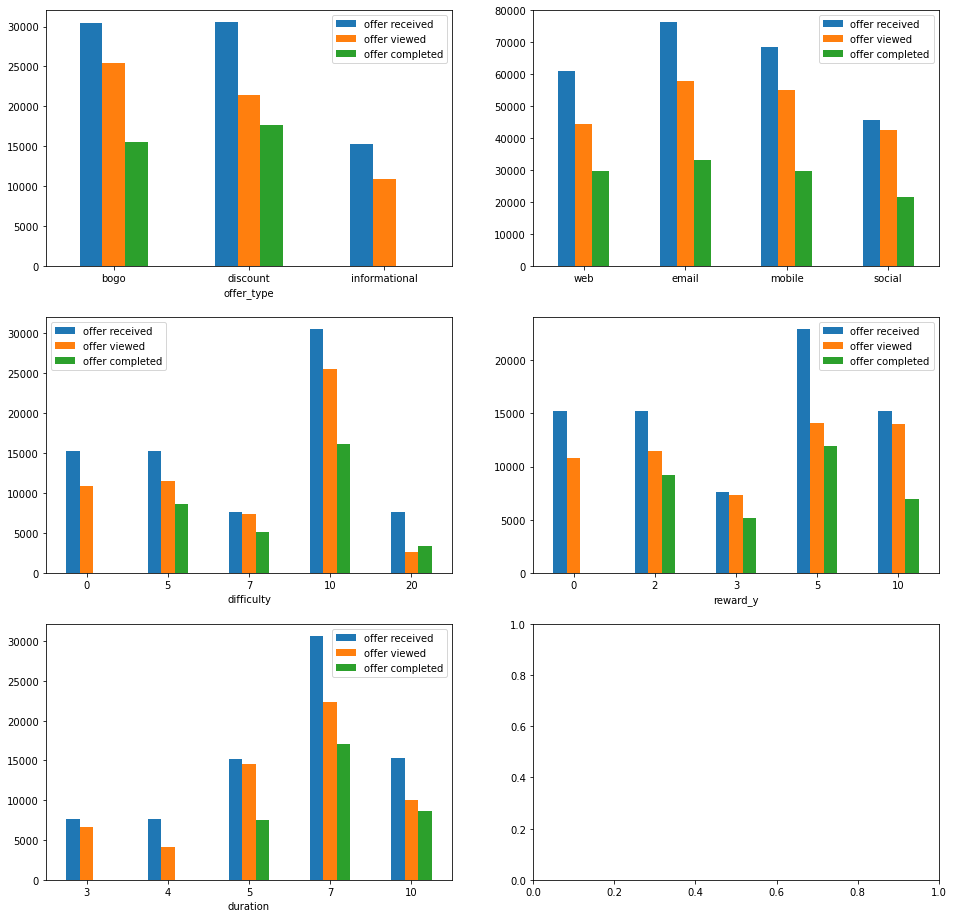

In [28]:
offer_categories = pd.merge(offer_purchase, portfolio_cleaned, how = 'left', on = 'offer id')

fig, axs = plt.subplots(3, 2, figsize = (16,16))

offer_type_event = offer_categories.groupby('offer_type')[['offer received', 'offer viewed', 'offer completed']].sum()
offer_type_event.plot(kind = 'bar', rot =0, ax = axs[0, 0])

offer_channel_event= pd.concat([
    offer_categories[offer_categories['web']==1][['offer received', 'offer viewed', 'offer completed']].sum(),
    offer_categories[offer_categories['email']==1][['offer received', 'offer viewed', 'offer completed']].sum(),
    offer_categories[offer_categories['mobile']==1][['offer received', 'offer viewed', 'offer completed']].sum(),
    offer_categories[offer_categories['social']==1][['offer received', 'offer viewed', 'offer completed']].sum()
], axis =1)
offer_channel_event.columns = ['web', 'email', 'mobile', 'social']
offer_channel_event = offer_channel_event.transpose()
offer_channel_event.plot(kind ='bar', rot = 0, ax = axs[0, 1])

offer_difficulty_event = offer_categories.groupby('difficulty')[['offer received', 'offer viewed', 'offer completed']].sum()
offer_difficulty_event.plot(kind = 'bar', rot =0, ax = axs[1,0])

offer_reward_event = offer_categories.groupby('reward_y')[['offer received', 'offer viewed', 'offer completed']].sum()
offer_reward_event.plot(kind = 'bar', rot =0, ax = axs[1,1])

offer_duration_event = offer_categories.groupby('duration')[['offer received', 'offer viewed', 'offer completed']].sum()
offer_duration_event.plot(kind = 'bar', rot =0, ax = axs[2,0])

plt.show()

From the plots above, for different offer types, it seems that discount offers have a higher completion rate than bogo offer, while have a lower view rate. Informaional offer has no completion actions. For offer delivery channels, it is clear that social media channel has the highest view rate compare to other channels. For offer difficulty and rewards amount, it is unclear how it correlates to the view and completion rates of offers. Lastly, for offer duration, it appears that longer duration offer does slightly increase the completion rate, however, the view rate is not affected by offer duration.

### 3.4 User responses

In this section we are going to explore how the users response to different offers. As we have assign the users into different groups based on their age, gender and income, we would like to check how each different group of users responds to the offers.

First we define 3 scenarios of user response to an offer, 
- 1. the user never complete the offer
- 2. the user complete the offer without viewing the offer
- 3. the user complete the offer and viewed the offer (every time the user receive the offer)
And we tag the result as 0, 1, and 2

In [35]:
# this function get the scenario result mentioned above for each user-offer interaction
def get_result(offer_purchase):
    '''
    
    this function get a dataframe with the result of each user interaction with each offer
    with not complete as 0, complete without view as 1 and complete with view as 2.
    
    
    INPUT: transcript_cleaned -processed transcript dataframe
    
    OUTPUT: offer_status - a dataframe with how each user interact with each offer
    
    '''
    
    # here we select the person, offer id and offer event related columns and group by the users and offers;
    # Then we added the offer events together, this gives us for one particular user and offer, 
    #how many times the user receive the offer, view the offer and complete the offer
    offer_status = offer_purchase.drop(['time'],axis =1).groupby(['person', 'offer id']).sum().reset_index()
    
    # here we want to tag all the different outcome of a user's interaction with an offer
    for i, row in offer_status.iterrows():
        x = 0
        # user never complete this offer, we tag the event as 0
        if offer_status.iloc[i]['offer completed'] == 0:
            x = 0
        # user completed this offer but sometimes completed it without viewing the offer, we tag the event as 1
        elif offer_status.iloc[i]['offer completed'] > offer_status.iloc[i]['offer viewed']:
            x = 1
        # user completed the offer with viewing the offer (regardless before or after using the offer), we tag the event as 2
        else:
            x = 2
        offer_status.at[i, 'result'] = x
    
    # drop the original offer event columns
    offer_status.drop(['offer received', 'offer viewed', 'offer completed', 'transaction', 'reward'], axis = 1, inplace = True)
    
    # conver the offer id and result to int
    offer_status[['offer id', 'result']] = offer_status[['offer id', 'result']].astype(int)
    
    return offer_status

In [36]:
# get the user-offer interaction result
user_response = get_result(offer_purchase)

# Here we want to combine the user information with the user-offer interaction result
# there are user ids in the transcript dataframe but not in the profile dataframe, since we want to understand the user
# behavior based on their demographic, we choose inner join here.
user_response = pd.merge(user_response, profile_cleaned, how= 'inner', left_on = 'person', right_on = 'id').drop(['id'], axis= 1)

First we want to see how each age groups reacts to each offer

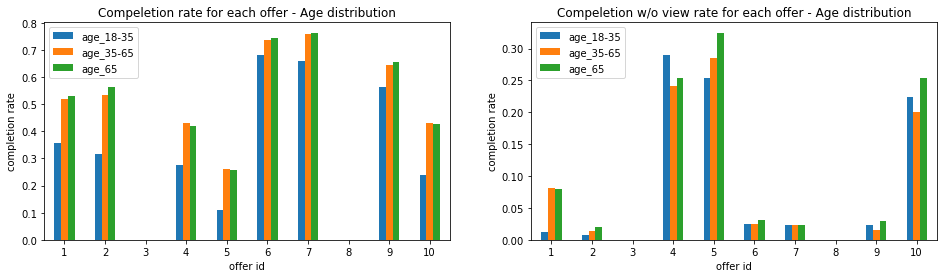

In [37]:
#Get the offer completion rate (tag 2) for all age groups 
age_completion_rate = user_response[user_response['result']==2].groupby(['offer id'])[['age_18-35', 'age_35-65', 'age_65']].sum()/user_response.groupby(['offer id'])[['age_18-35', 'age_35-65', 'age_65']].sum()

#Get the offer completion w/o view rate (tag 1) for all age groups 
age_no_view = user_response[user_response['result']==1].groupby(['offer id'])[['age_18-35', 'age_35-65', 'age_65']].sum()/user_response.groupby(['offer id'])[['age_18-35', 'age_35-65', 'age_65']].sum()

#Create visualization
fig, axs = plt.subplots(1, 2, figsize = (16,4))
age_completion_rate.plot(ax = axs[0], kind ='bar', title ='Compeletion rate for each offer - Age distribution', rot =0)
axs[0].set_ylabel('completion rate')
age_no_view.plot(ax = axs[1],kind = 'bar', title ='Compeletion w/o view rate for each offer - Age distribution', rot= 0)
axs[1].set_ylabel('completion rate')
plt.show()

Now check how each income groups reacts to each offer

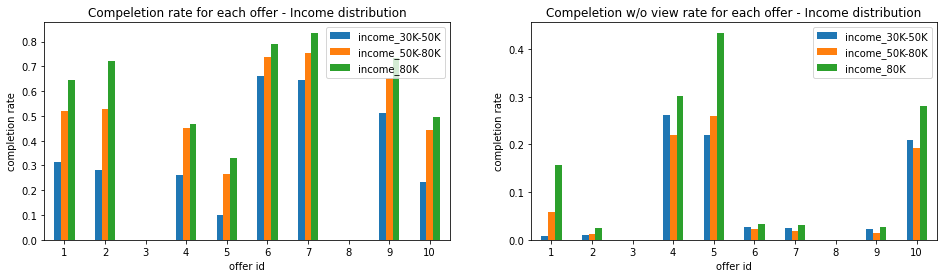

In [38]:
#Get the offer completion rate (tag 2) for all income groups 
income_completion_rate = user_response[user_response['result']==2].groupby(['offer id'])[['income_30K-50K', 'income_50K-80K','income_80K']].sum()/user_response.groupby(['offer id'])[['income_30K-50K', 'income_50K-80K','income_80K']].sum()
#Get the offer completion w/o view rate (tag 1) for all income groups 
income_no_view = user_response[user_response['result']==1].groupby(['offer id'])[['income_30K-50K', 'income_50K-80K','income_80K']].sum()/user_response.groupby(['offer id'])[['income_30K-50K', 'income_50K-80K','income_80K']].sum()


fig, axs = plt.subplots(1, 2, figsize = (16,4))

income_completion_rate.plot(ax = axs[0], kind ='bar', title ='Compeletion rate for each offer - Income distribution')
axs[0].set_xticklabels(portfolio_cleaned['offer id'], rotation = 0)
axs[0].set_ylabel('completion rate')
income_no_view.plot(ax = axs[1],kind = 'bar', title ='Compeletion w/o view rate for each offer - Income distribution')
axs[1].set_xticklabels(portfolio_cleaned['offer id'], rotation = 0)
axs[1].set_ylabel('completion rate')
plt.show()

Different gender group's interaction with offers

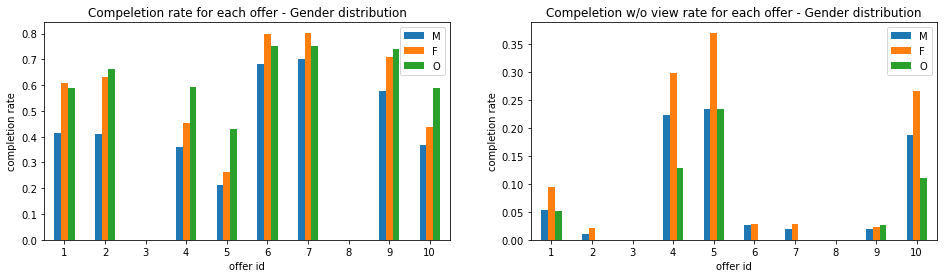

In [39]:
#Get the offer completion rate (tag 2) for all gender groups 
gender_completion_rate = user_response[user_response['result']==2].groupby(['offer id'])[['M', 'F', 'O']].sum()/user_response.groupby(['offer id'])[['M', 'F', 'O']].sum()
#Get the offer completion w/o view rate (tag 1) for all gender groups 
gender_no_view = user_response[user_response['result']==1].groupby(['offer id'])[['M', 'F', 'O']].sum()/user_response.groupby(['offer id'])[['M', 'F', 'O']].sum()


fig, axs = plt.subplots(1, 2, figsize = (16,4))
gender_completion_rate.plot(ax = axs[0], kind ='bar', title ='Compeletion rate for each offer - Gender distribution')
axs[0].set_xticklabels(portfolio_cleaned['offer id'], rotation = 0)
axs[0].set_ylabel('completion rate')
gender_no_view.plot(ax = axs[1],kind = 'bar', title ='Compeletion w/o view rate for each offer - Gender distribution')
axs[1].set_xticklabels(portfolio_cleaned['offer id'], rotation = 0)
axs[1].set_ylabel('completion rate')
plt.show()

The influence of membership age on the offer interaction results

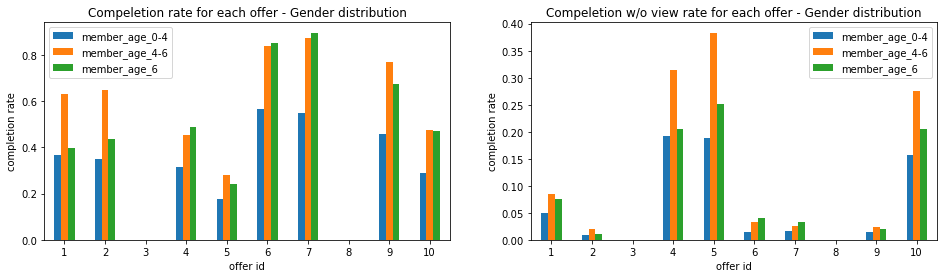

In [40]:
membership_age_completion_rate = user_response[user_response['result']==2].groupby(['offer id'])[['member_age_0-4', 'member_age_4-6', 'member_age_6']].sum()/user_response.groupby(['offer id'])[['member_age_0-4', 'member_age_4-6', 'member_age_6']].sum()

membership_age_no_view = user_response[user_response['result']==1].groupby(['offer id'])[['member_age_0-4', 'member_age_4-6', 'member_age_6']].sum()/user_response.groupby(['offer id'])[['member_age_0-4', 'member_age_4-6', 'member_age_6']].sum()


fig, axs = plt.subplots(1, 2, figsize = (16,4))

membership_age_completion_rate.plot(ax = axs[0], kind ='bar', rot = 0, title ='Compeletion rate for each offer - Gender distribution')
axs[0].set_ylabel('completion rate')
membership_age_no_view.plot(ax = axs[1],kind = 'bar', rot =0, title ='Compeletion w/o view rate for each offer - Gender distribution')
axs[1].set_ylabel('completion rate')
plt.show()

From the analysis above, we get the following infomation:

1. Age Groups

For offer completed with viewing, users in 35-65 and 65 above age group have a higher completion rate. For offer completed without viewing, the first thing we notice is that offer 4, 5 and 10 have much higer rate than the rest of the offers. And for offer 4 and 10, users in 18-35 and above 65 Age group are more likely to complete the offer without viewing, while for offer 5, the completion rate increases as age increase.

2. Income Groups

For completion with viewing, user in higher income groups shows higher completiong rate among all offers. For completion without viewing, same as age groups, offer 4, 5, 10 shows higher rate, and the distribution trend for these offers is similar to Age groups as well.

3. Gender Groups

For both completion with viewing and without viewing, male users have relatively low completion rate. And female users have higher completion without viewing rate.

4. Membership Age

For most offers, the users with 4-6 years of membership shows higher completion rate both with and without viewing the offer. 

To conclude this part, users in older age groups, with higher income, female and other gender users, users with longer membership age are more likely to view the offer and complete the offer. On the other hand, users with higher income, female users, and users with membership age between 4-6 years are more likely to complete an offer without viewing the offer.

Besides the different reactions to offers among different groups, one common result we noticed from this is for offer 4, 5 and 10, they have relatively high complete without view rate. And this is also noticed in the offer performance section, that because these offers were not delivered through "social media" channel, they have a relatively low viewing rate comparing to other offers.

#### 3.5 Combine User and Offer Data

Now it is time to combine all the infomation together, and prepare for next steps.

In [41]:
#first combine the user-offer interaction dataframe with the offer information dataframe
result = pd.merge(user_response, portfolio_cleaned, how = 'left', on = 'offer id')
result

,person,offer id,amount,result,gender,age,became_member_on,income,membership age,age_18-35,...,member_age_4-6,member_age_6,offer_type,web,email,mobile,social,reward,difficulty,duration
0,0009655768c64bdeb2e877511632db8f,3,0.00,0,M,33,2017-04-21,72000.0,1628,1,...,1,0,informational,1,1,1,0,0,0,4
1,0009655768c64bdeb2e877511632db8f,7,14.11,2,M,33,2017-04-21,72000.0,1628,1,...,1,0,discount,1,1,1,1,2,10,10
2,0009655768c64bdeb2e877511632db8f,8,0.00,0,M,33,2017-04-21,72000.0,1628,1,...,1,0,informational,0,1,1,1,0,0,3
3,0009655768c64bdeb2e877511632db8f,9,8.57,2,M,33,2017-04-21,72000.0,1628,1,...,1,0,bogo,1,1,1,1,5,5,5
4,0009655768c64bdeb2e877511632db8f,10,20.54,1,M,33,2017-04-21,72000.0,1628,1,...,1,0,discount,1,1,1,0,2,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,9,19.15,2,M,34,2017-01-23,34000.0,1716,1,...,1,0,bogo,1,1,1,1,5,5,5
55218,ffff82501cea40309d5fdd7edcca4a07,4,15.58,2,F,45,2016-11-25,62000.0,1775,0,...,1,0,bogo,1,1,1,0,5,5,7
55219,ffff82501cea40309d5fdd7edcca4a07,5,22.88,2,F,45,2016-11-25,62000.0,1775,0,...,1,0,discount,1,1,0,0,5,20,10
55220,ffff82501cea40309d5fdd7edcca4a07,7,16.06,2,F,45,2016-11-25,62000.0,1775,0,...,1,0,discount,1,1,1,1,2,10,10


Before we move to using machine learning classifiers to predict how users interact with different offers, here we take a look at the summary how user age, income and membership age affects their interaction with offers.

1. User Age

Same as the conclusion we obtained from previous section, users at younger age (< 30 years old) are more likely to not complete the offer, while people at older age ( > 30 years old) are more likely to complete the offer). More importantly, people younger than 45 years old are more unlikely to complete an offer without viewing the offer.
    
2. User Income

Similar to the conclusion from the previous section, users with higher income are more likely to complete the offer or complete the offer without view the offer, while users with lower income have a relatively lowers completion rate
    
3. Membership Age

For this metrit, users showed the same trend for complete and complete without view the offer. That is the longer the users as members, they are more likely to complete the offer with or without view. But for users with shorter membership age, they are less likely to complete an offer.

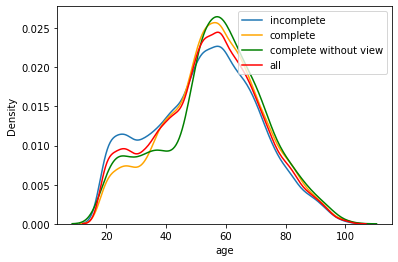

In [42]:
# get the kde plot for the user age with result = 0, 1, 2 and all user age
sns.kdeplot(data = result[result['result']==0]['age'],label = 'incomplete')
sns.kdeplot(data = result[result['result']==2]['age'], color = 'orange', label = 'complete')
sns.kdeplot(data = result[result['result']==1]['age'], color = 'green', label ='complete without view')
sns.kdeplot(data = result['age'], color = 'red', label ='all')
plt.legend()
plt.show()

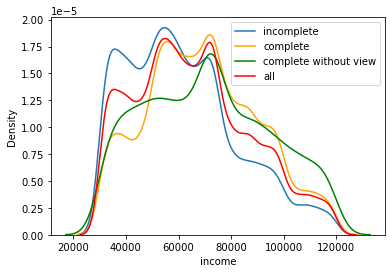

In [43]:
# get the kde plot for the user income with result = 0, 1, 2 and all user income

sns.kdeplot(data = result[result['result']==0]['income'], label = 'incomplete')
sns.kdeplot(data = result[result['result']==2]['income'], color = 'orange', label = 'complete')
sns.kdeplot(data = result[result['result']==1]['income'], color = 'green', label = 'complete without view')
sns.kdeplot(data = result['income'], color = 'red', label = 'all')
plt.legend()
plt.show()

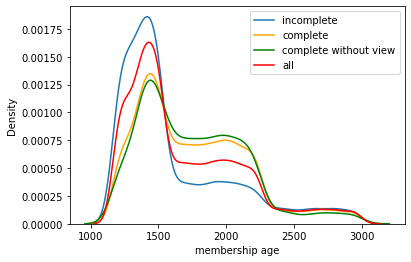

In [44]:
# get the kde plot for the user membership age with result = 0, 1, 2 and all user membership age

sns.kdeplot(data = result[result['result']==0]['membership age'], label = 'incomplete')
sns.kdeplot(data = result[result['result']==2]['membership age'], color = 'orange', label = 'complete')
sns.kdeplot(data = result[result['result']==1]['membership age'], color = 'green', label = 'complete without view')
sns.kdeplot(data = result['membership age'], color = 'red', label = 'all')
plt.legend()
plt.show()

#### Some Final Preperation

Since we know that for informational type of offer, there is no offer completion event, therefore, for this classfication study. We only take the offers with completion event, which will have the user-offer interaction result as 0, 1, and 2.

In [45]:
# selete the only the bogo and discount entries
result_wo_info = result[result['offer_type']!='informational']
# get dummy columns for offer type
offer_type = pd.get_dummies(result_wo_info['offer_type'])
result_wo_info = pd.concat([result_wo_info, offer_type.set_index(result_wo_info.index)], axis =1)
result_wo_info.drop(['offer_type'], axis = 1, inplace = True)
result_wo_info

,person,offer id,amount,result,gender,age,became_member_on,income,membership age,age_18-35,...,member_age_6,web,email,mobile,social,reward,difficulty,duration,bogo,discount
1,0009655768c64bdeb2e877511632db8f,7,14.11,2,M,33,2017-04-21,72000.0,1628,1,...,0,1,1,1,1,2,10,10,0,1
3,0009655768c64bdeb2e877511632db8f,9,8.57,2,M,33,2017-04-21,72000.0,1628,1,...,0,1,1,1,1,5,5,5,1,0
4,0009655768c64bdeb2e877511632db8f,10,20.54,1,M,33,2017-04-21,72000.0,1628,1,...,0,1,1,1,0,2,10,7,0,1
6,0011e0d4e6b944f998e987f904e8c1e5,4,22.05,2,O,40,2018-01-09,57000.0,1365,0,...,0,1,1,1,0,5,5,7,1,0
7,0011e0d4e6b944f998e987f904e8c1e5,5,22.05,2,O,40,2018-01-09,57000.0,1365,0,...,0,1,1,0,0,5,20,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,9,19.15,2,M,34,2017-01-23,34000.0,1716,1,...,0,1,1,1,1,5,5,5,1,0
55218,ffff82501cea40309d5fdd7edcca4a07,4,15.58,2,F,45,2016-11-25,62000.0,1775,0,...,0,1,1,1,0,5,5,7,1,0
55219,ffff82501cea40309d5fdd7edcca4a07,5,22.88,2,F,45,2016-11-25,62000.0,1775,0,...,0,1,1,0,0,5,20,10,0,1
55220,ffff82501cea40309d5fdd7edcca4a07,7,16.06,2,F,45,2016-11-25,62000.0,1775,0,...,0,1,1,1,1,2,10,10,0,1


Now lets take a look at how the columns correlates to each other, especially how each column correlates with the 'result' column. This information is useful in selecting features to predict the result.

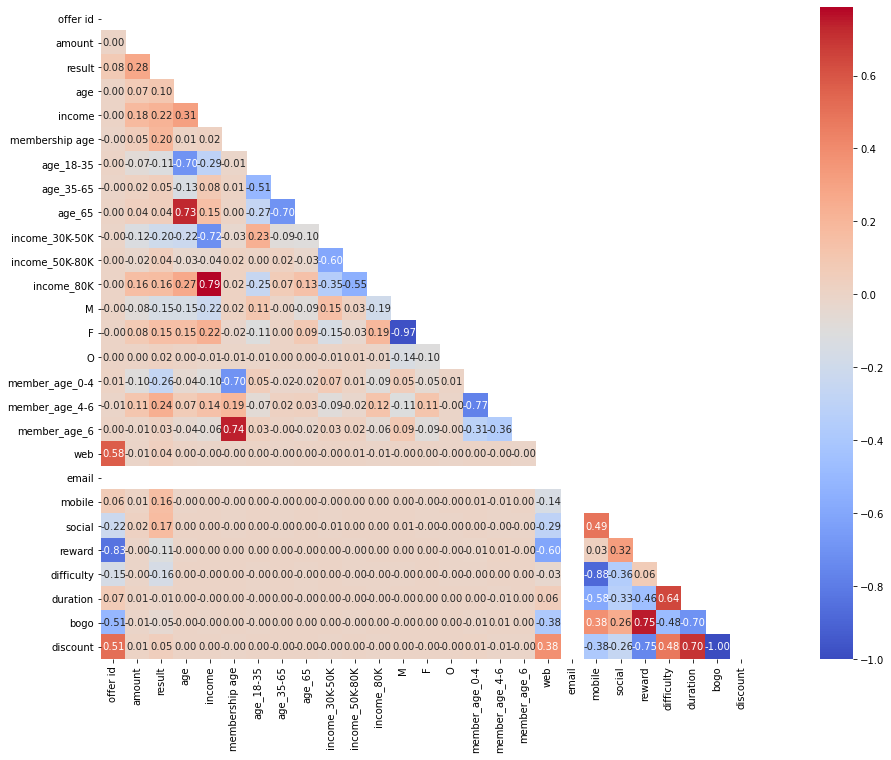

In [46]:
# import package
import matplotlib

# create correlation heat map
matplotlib.rcParams.update({'font.size': 10})
corr = result_wo_info.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,12))
sns.heatmap(corr, mask = mask, square = True, annot = True, fmt = '.2f', cmap ='coolwarm')
plt.show()

### 4. Classifier

The goal of this section is to build a machine learning classifier to predict the user interaction with different offers from the user information and offer information. By using different classification algorithms, we would like to identify which algorithm can yield the best performance.

First we need to determine the y (the value we are trying to predict) and X (the values used to predict y) for this classifer.
Since we are trying to predict the outcome of user-offer interaction, which we set 3 different out comes as 0, 1, and 2, here we set the 'result' column as y.

In [93]:
# set y values as the 'result' column which is the value we are trying to predict
y = result_wo_info['result']

For x values, we first drop the values that are 1. not numerical ('gender' (str), 'became_member_on' (datetime)) 2. the same across the dataframe ('email') and we only select values that are relavent to determine the result value, columns such as user id and offer id are not selected either.

In [94]:
# set X values
x = result_wo_info[result_wo_info.columns[4:]].drop(['email', 'became_member_on', 'gender'], axis =1)
x

,age,income,membership age,age_18-35,age_35-65,age_65,income_30K-50K,income_50K-80K,income_80K,M,...,member_age_4-6,member_age_6,web,mobile,social,reward,difficulty,duration,bogo,discount
1,33,72000.0,1628,1,0,0,0,1,0,1,...,1,0,1,1,1,2,10,10,0,1
3,33,72000.0,1628,1,0,0,0,1,0,1,...,1,0,1,1,1,5,5,5,1,0
4,33,72000.0,1628,1,0,0,0,1,0,1,...,1,0,1,1,0,2,10,7,0,1
6,40,57000.0,1365,0,1,0,0,1,0,0,...,0,0,1,1,0,5,5,7,1,0
7,40,57000.0,1365,0,1,0,0,1,0,0,...,0,0,1,0,0,5,20,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,34,34000.0,1716,1,0,0,1,0,0,1,...,1,0,1,1,1,5,5,5,1,0
55218,45,62000.0,1775,0,1,0,0,1,0,0,...,1,0,1,1,0,5,5,7,1,0
55219,45,62000.0,1775,0,1,0,0,1,0,0,...,1,0,1,0,0,5,20,10,0,1
55220,45,62000.0,1775,0,1,0,0,1,0,0,...,1,0,1,1,1,2,10,10,0,1


Before we us ML classifiers to train our model, first, we need to normalzied the data onto the same scale. Here we use the MinMax Scaler to scale our data onto 0 to 1 scale

In [95]:
# import package
from sklearn.preprocessing import MinMaxScaler

#apply the scaler
scaler = MinMaxScaler()

scaler.fit(x[['reward', 'difficulty', 'duration', 'age', 'income', 'membership age']])

x[['reward', 'difficulty', 'duration', 'age', 'income', 'membership age']] = scaler.transform(x[['reward', 'difficulty', 'duration', 'age', 'income', 'membership age']])

In [96]:
# check how x looks like
x

,age,income,membership age,age_18-35,age_35-65,age_65,income_30K-50K,income_50K-80K,income_80K,M,...,member_age_4-6,member_age_6,web,mobile,social,reward,difficulty,duration,bogo,discount
1,0.180723,0.466667,0.252880,1,0,0,0,1,0,1,...,1,0,1,1,1,0.000,0.333333,1.0,0,1
3,0.180723,0.466667,0.252880,1,0,0,0,1,0,1,...,1,0,1,1,1,0.375,0.000000,0.0,1,0
4,0.180723,0.466667,0.252880,1,0,0,0,1,0,1,...,1,0,1,1,0,0.000,0.333333,0.4,0,1
6,0.265060,0.300000,0.108612,0,1,0,0,1,0,0,...,0,0,1,1,0,0.375,0.000000,0.4,1,0
7,0.265060,0.300000,0.108612,0,1,0,0,1,0,0,...,0,0,1,0,0,0.375,1.000000,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,0.192771,0.044444,0.301152,1,0,0,1,0,0,1,...,1,0,1,1,1,0.375,0.000000,0.0,1,0
55218,0.325301,0.355556,0.333516,0,1,0,0,1,0,0,...,1,0,1,1,0,0.375,0.000000,0.4,1,0
55219,0.325301,0.355556,0.333516,0,1,0,0,1,0,0,...,1,0,1,0,0,0.375,1.000000,1.0,0,1
55220,0.325301,0.355556,0.333516,0,1,0,0,1,0,0,...,1,0,1,1,1,0.000,0.333333,1.0,0,1


Import packages for using different classfiers to test the performance of models.

In [97]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Create the function to perform classification and evaluate its performance

In [116]:
# define the function to create the classifier and evaluate its performance.
def classifier(clf, X_train, X_test, y_train, y_test):
    '''
    this function takes in the classifier name, X_train, y_train value and use this classifier to predict the
    y. And the predicted y value using the X_test value is compare with the y_test value. Finally a confusion matrix 
    visualization is made, and the classification report is printed.
    
    INPUT: clf - classifer
           X_train, y_train - training set
           X_test, y_test, -test rest
    
    OUTPUT:
           labels
           confusion matrix
           confusion matrix visulization
           classification report
    
    '''
        
    #fit the classifier with training set
    clf.fit(X_train, y_train)
    
    #predict y using the trained classifer and X_test
    y_pred = clf.predict(X_test)
    
    #get the labels in the y_pred set
    labels = np.unique(y_pred)
    # get the confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)

    #visulize confusion matrix
    make_confusion_matrix(confusion_mat, percent = False, cmap='Blues', title = 'Confusion Matrix')
    
    #get the classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    #return the trained classifier
    return
    clf

Here we also introduced a function to perform confusion matrix visulization, it is not strictly necessary, the confusion matrix can be print out as an array, however, this visualization did a better job. And here I would like to credit to Dtrmarchi10 on Github 
github.com/DTimarchi10/confusion_matrix

In [117]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

Before we move on the try all the different classfication algorithms avaible, first we need to identity what kind of classficiation we are tying to perform here. Since we are tying to classify the results into 3 different outcomes, this is a multi-class classficiation problem. According to this article, https://machinelearningmastery.com/types-of-classification-in-machine-learning/, here are several popular algorithms that can be used for multi-class classification:

1. Random Forest
2. K-Nearest Neighbors
3. Naive Bayers
4. Decision Trees
5. Support Vector Machine
6. Gradient Boosting
7. LogisticRegression classifier

Therefore, here we are going to test all these algorithms to evaluate their performance

1. Ramdon Forest

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.58      0.58      3240
           1       0.37      0.26      0.30      1040
           2       0.68      0.72      0.70      4557

    accuracy                           0.62      8837
   macro avg       0.54      0.52      0.53      8837
weighted avg       0.61      0.62      0.61      8837



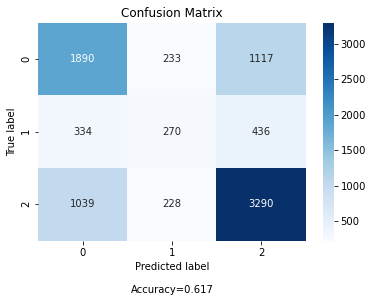

In [118]:
# Random Forest Classifer
clf = RandomForestClassifier()
classifier(clf, X_train, X_test, y_train, y_test)

2. k-Nearest Neighors

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.61      0.58      3240
           1       0.34      0.25      0.29      1040
           2       0.69      0.68      0.69      4557

    accuracy                           0.60      8837
   macro avg       0.53      0.51      0.52      8837
weighted avg       0.60      0.60      0.60      8837



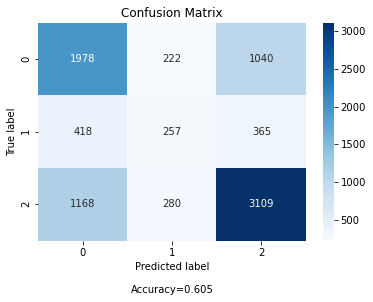

In [119]:
# KNeighboursClassifer
clf = KNeighborsClassifier()
classifier(clf, X_train, X_test, y_train, y_test)

3. Naive Bayers

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.50      0.54      3240
           1       0.33      0.40      0.36      1040
           2       0.68      0.72      0.70      4557

    accuracy                           0.60      8837
   macro avg       0.53      0.54      0.53      8837
weighted avg       0.61      0.60      0.60      8837



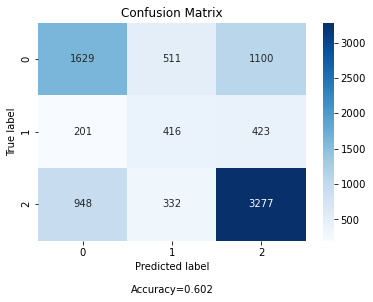

In [120]:
# Gassian NB classifer
gnb = GaussianNB()
classifier(gnb, X_train, X_test, y_train, y_test)

4. Decision Tree

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.55      0.54      3240
           1       0.28      0.29      0.28      1040
           2       0.66      0.65      0.65      4557

    accuracy                           0.57      8837
   macro avg       0.49      0.49      0.49      8837
weighted avg       0.57      0.57      0.57      8837



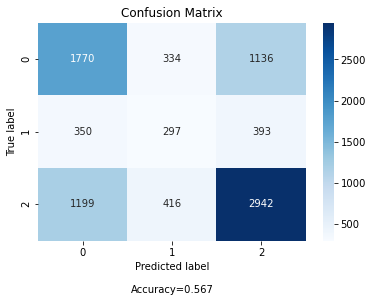

In [121]:
# Decision Tree Classifer
clf = DecisionTreeClassifier()
classifier(clf, X_train, X_test, y_train, y_test)

5. Support Vector Machine

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.57      0.58      3240
           1       0.44      0.13      0.20      1040
           2       0.66      0.79      0.72      4557

    accuracy                           0.63      8837
   macro avg       0.56      0.50      0.50      8837
weighted avg       0.61      0.63      0.61      8837



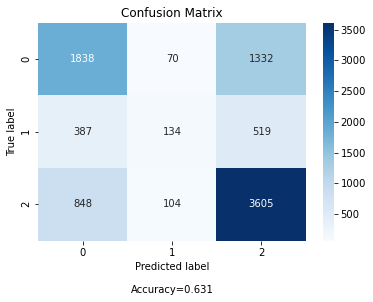

In [122]:
# test the Support Vector Machine classifier

clf = SVC(gamma='auto')
classifier(clf, X_train, X_test, y_train, y_test)

6. Gradient Boosting

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.62      0.63      3240
           1       0.43      0.29      0.35      1040
           2       0.70      0.76      0.73      4557

    accuracy                           0.66      8837
   macro avg       0.59      0.56      0.57      8837
weighted avg       0.64      0.66      0.65      8837



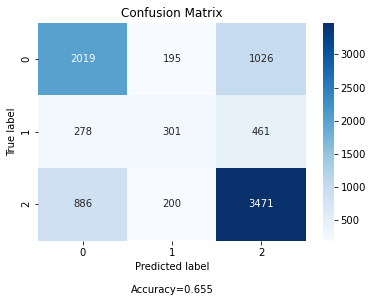

In [123]:
# test the Gradient Boosting classifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
classifier(clf, X_train, X_test, y_train, y_test)

7. Logistic Regression classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.57      0.59      3240
           1       0.43      0.18      0.25      1040
           2       0.67      0.78      0.72      4557

    accuracy                           0.63      8837
   macro avg       0.57      0.51      0.52      8837
weighted avg       0.62      0.63      0.62      8837



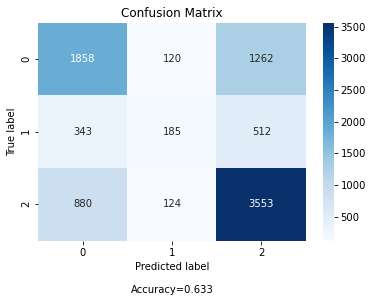

In [124]:
# test the LogisticRegression classifier

clf = LogisticRegression(random_state=0, max_iter = 1000)
classifier(clf, X_train, X_test, y_train, y_test)

From the above result, it is clear that the Gradient Boosting algorithm shows the best performance among all the algorithms that we tested. However, it seems that the performance is still not ideal, especially on label 1, which is purchase without viewing the offer. This might be due to the selection of features X.So here we decided to do the following treatment to the X arrays:

1. drop redundant columns (e.g. age and age groups)

In [125]:
x.drop(['age_18-35', 'age_35-65', 'age_65', 'income_30K-50K',  'income_50K-80K',  'income_80K', 'member_age_0-4', 'member_age_6', 'member_age_4-6'], axis = 1, inplace = True)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64      3207
           1       0.47      0.27      0.34      1051
           2       0.70      0.77      0.74      4579

    accuracy                           0.66      8837
   macro avg       0.60      0.56      0.57      8837
weighted avg       0.65      0.66      0.65      8837



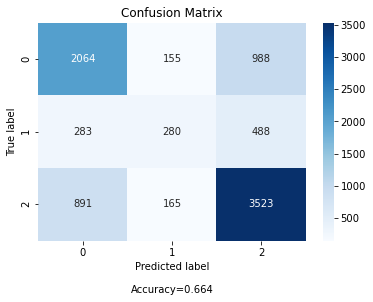

In [127]:
# test the Gradient Boosting classifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
classifier(clf, X_train, X_test, y_train, y_test)

It seems that this slightly improve the classifer performance, but not by a large margin. 

2. Grid Search

Let's try grid search here to see if we can find better parameters in the classifer.

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END ..learning_rate=1, max_depth=3, n_estimators=50; total time=   2.7s
[CV 2/3] END ..learning_rate=1, max_depth=3, n_estimators=50; total time=   2.7s
[CV 3/3] END ..learning_rate=1, max_depth=3, n_estimators=50; total time=   2.7s
[CV 1/3] END .learning_rate=1, max_depth=3, n_estimators=100; total time=   5.3s
[CV 2/3] END .learning_rate=1, max_depth=3, n_estimators=100; total time=   5.3s
[CV 3/3] END .learning_rate=1, max_depth=3, n_estimators=100; total time=   5.3s
[CV 1/3] END .learning_rate=1, max_depth=3, n_estimators=200; total time=  10.6s
[CV 2/3] END .learning_rate=1, max_depth=3, n_estimators=200; total time=  10.6s
[CV 3/3] END .learning_rate=1, max_depth=3, n_estimators=200; total time=  11.2s
[CV 1/3] END ..learning_rate=1, max_depth=6, n_estimators=50; total time=   5.0s
[CV 2/3] END ..learning_rate=1, max_depth=6, n_estimators=50; total time=   4.9s
[CV 3/3] END ..learning_rate=1, max_depth=6, n_e

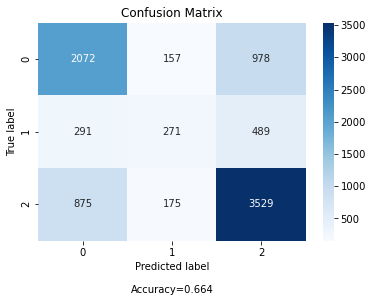

In [129]:
# run grid search for gradient boosting
parameters = {"n_estimators":[50,100,200], 
              "learning_rate": [1,0.1,0.05],
             "max_depth":[3,6,9]}
GBC = GradientBoostingClassifier(random_state = 1)
clf = GridSearchCV(GBC, parameters, cv =3,verbose = 3) 
classifier(clf, X_train, X_test, y_train, y_test)

It seems the accuracy slightly improves.

In [130]:
# find the best parameters
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.63      0.63      3263
           1       0.43      0.28      0.34       976
           2       0.71      0.76      0.73      4598

    accuracy                           0.66      8837
   macro avg       0.59      0.56      0.57      8837
weighted avg       0.65      0.66      0.65      8837



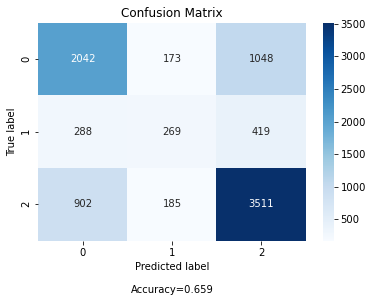

In [131]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=1)
classifier(clf, X_train, X_test, y_train, y_test)

It seems that the classifier is still have trouble with 'result' = 1 (completion without view). As we discussed in the exploretary analysis, this mostly happens to offers delivered without using 'social media' channel. Therefore, here we want to test how our classifier performs on these offers. These offers are offer 3, 4, 5 and 10. Since offer 3 is a informational offer, here we are not taking it into account.

In [132]:
# get the entries for offers not delivered through social media
result_low_view = result_wo_info[result_wo_info['offer id'].isin( [4, 5, 10])]

In [133]:
# check the obtained dataframe
result_low_view

,person,offer id,amount,result,gender,age,became_member_on,income,membership age,age_18-35,...,member_age_6,web,email,mobile,social,reward,difficulty,duration,bogo,discount
4,0009655768c64bdeb2e877511632db8f,10,20.54,1,M,33,2017-04-21,72000.0,1628,1,...,0,1,1,1,0,2,10,7,0,1
6,0011e0d4e6b944f998e987f904e8c1e5,4,22.05,2,O,40,2018-01-09,57000.0,1365,0,...,0,1,1,1,0,5,5,7,1,0
7,0011e0d4e6b944f998e987f904e8c1e5,5,22.05,2,O,40,2018-01-09,57000.0,1365,0,...,0,1,1,0,0,5,20,10,0,1
14,0020ccbbb6d84e358d3414a3ff76cffd,4,10.32,2,F,24,2016-11-11,60000.0,1789,1,...,0,1,1,1,0,5,5,7,1,0
19,003d66b6608740288d6cc97a6903f4f0,5,7.26,1,F,26,2017-06-21,73000.0,1567,1,...,0,1,1,0,0,5,20,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55210,fff7576017104bcc8677a8d63322b5e1,4,8.01,1,M,71,2017-10-31,73000.0,1435,0,...,0,1,1,1,0,5,5,7,1,0
55215,fffad4f4828548d1b5583907f2e9906b,4,10.98,2,M,34,2017-01-23,34000.0,1716,1,...,0,1,1,1,0,5,5,7,1,0
55218,ffff82501cea40309d5fdd7edcca4a07,4,15.58,2,F,45,2016-11-25,62000.0,1775,0,...,0,1,1,1,0,5,5,7,1,0
55219,ffff82501cea40309d5fdd7edcca4a07,5,22.88,2,F,45,2016-11-25,62000.0,1775,0,...,0,1,1,0,0,5,20,10,0,1


In [134]:
# set y value
y = result_low_view['result']

In [135]:
# set x values
x = result_low_view[result_low_view.columns[4:]].drop(['email', 'became_member_on', 'gender'], axis =1)

# Before we us ML classifiers to train our model, first, we need to normalzied the data onto the same scale
# Here we use the MinMax Scaler to scale our data onto 0 to 1 scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(x[['reward', 'difficulty', 'duration', 'age', 'income', 'membership age']])

x[['reward', 'difficulty', 'duration', 'age', 'income', 'membership age']] = scaler.transform(x[['reward', 'difficulty', 'duration', 'age', 'income', 'membership age']])

# drop the redundant columns as before, only keep the useful features
x = x[['age', 'income', 'membership age', 'M', 'F', 'O', 'web', 'mobile', 'social', 'reward', 'difficulty', 'duration', 'bogo', 'discount']]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.68      0.65      1377
           1       0.39      0.32      0.35       785
           2       0.55      0.55      0.55      1160

    accuracy                           0.55      3322
   macro avg       0.52      0.52      0.52      3322
weighted avg       0.54      0.55      0.54      3322



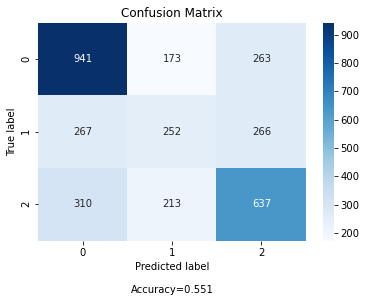

In [136]:
# use gradientboosting algorithm to classify the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=1)
classifier(clf, X_train, X_test, y_train, y_test)

The classifier performed better on this dataset for label 1 (complete without view), but didn't improve the overall performance of this classifier. 

Let's go back to the original classifer

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.64      0.63      3253
           1       0.43      0.29      0.35       947
           2       0.71      0.75      0.73      4637

    accuracy                           0.66      8837
   macro avg       0.59      0.56      0.57      8837
weighted avg       0.65      0.66      0.65      8837



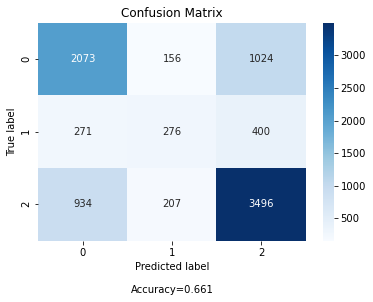

In [137]:
# get the full X and y dataset (include all offers)
y = result_wo_info['result']
x = result_wo_info[result_wo_info.columns[4:]].drop(['email', 'became_member_on', 'gender'], axis =1)
scaler = MinMaxScaler()
scaler.fit(x[['reward', 'difficulty', 'duration', 'age', 'income', 'membership age']])
x[['reward', 'difficulty', 'duration', 'age', 'income', 'membership age']] = scaler.transform(x[['reward', 'difficulty', 'duration', 'age', 'income', 'membership age']])
x.drop(['age_18-35', 'age_35-65', 'age_65', 'income_30K-50K',  'income_50K-80K',  'income_80K', 'member_age_0-4', 'member_age_6', 'member_age_4-6'], axis = 1, inplace = True)

# use gradientboosting algorithm to classify the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=1)
classifier(clf, X_train, X_test, y_train, y_test)


In [138]:
# A quick test on the classifier prediction
# predict the first 3 entries in the dataset
clf.predict(x.iloc[0:3])

array([2, 2, 1])

In [140]:
# the actual result of user-offer interaction
y.iloc[0:3]

1    2
3    2
4    1
Name: result, dtype: int64

The classifer work as expected. Therefore we can apply this classifier to predict how users with interact with different offers.

### 5. Summary

To summarize this project. The goal of this project is to study how users responses to the offers Starbucks sent out to help Starbuck how to better send out specific offer to centain users. There are 4 main parts of this project.

The first part is Load Data which involves loading the data from data files into Pandas dataframes for data cleaning and analysis. 

The second part is Data Cleaning which prepares data for Exploretary anaysis and Classifier anaylsis. In this part, we extract information such as offer ids from the columns that are originally filled with strings. Several columns with string values has also been coverted to numberical columns by using dummy column method, etc. Several new columns that divide users into some subgourps were also created.

The third part is the Exploretary Analysis which we analyzed how each offer different from each other, how they performed, and how different groups of users responsed to offers. From the anaysis, we concluded that offer #2 is the most successful offer and offer # 7 is the least successful in terms of revenue vs. cost. Social media is a powerful tool to reach users, because based on the data, the offers that was not delivered through social media, have a relatively low view rate. Another observation is that offers with longer duration seems to have a better completion rate than shorter durations. Besides these, the influnece of offer difficulty, offer type and rewards amount is not very clear from exploretary analysis.
From the user aspect, users in older age groups, with higer income, female and other gender users, users with longer membership age are more likely to view the offer and complete the offer. On the other hand, users with higer income, female users, and users with membership age between 4-6 years are more likely to complete an offer without viewing the offer.
From the Transaction aspect, it is similar conclusion to the user aspect, that users with higher income, longer membership age and older age are more likely to complete offers with or without views.

Lastly, the fourth part is classfier, in which we are trying to build a classifer that takes in user and offer information and predicts the users response to offers. Here we categorized the user and offer interaction into 3 categories: 1. did not complete the offer (category 0), 2. complete the offer without view (category 1) and 3. complete the offer with view (category 2). We tested using different subset of the data and differnet classifers. And finally determine that the gradientboosting classfier performs the best with using the entire cleaned dataset have the best performance. 

To sent out more successful offers, I think Starbucks should consider enhance the delivery of offers through social media channels. This can improve the view rate of the offers. And should also consider increase the duration of the offers to attract more users to complete the offers. Another action, the Starbucks can take is to recude the reward values of the offer, which can reduce the cost while not significantly impact the revenue. Lastly, Starbucks should design offers to that allow more younger users, users with shorter membership age and users with lower income. This can drive up the offer completion rate and potentially increase the overall revenue. 
